In [290]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [387]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

idx_train = (y_train == 5) | (y_train == 7)
x_train = x_train[idx_train,:]
y_train = y_train[idx_train]
idx_test = (y_test == 5) | (y_test == 7)
x_test = x_test[idx_test,:]
y_test = y_test[idx_test]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
cat_dim = 1
epochs = 20

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', name='encoder_intermediate')(inputs)

z_mean_1 = Dense(latent_dim, name='z_mean_1')(x)
z_log_var_1 = Dense(latent_dim, name='z_log_var_1')(x)
z_mean_2 = Dense(latent_dim, name='z_mean_2')(x)
z_log_var_2 = Dense(latent_dim, name='z_log_var_2')(x)

c = Dense(cat_dim, activation='sigmoid')(x)
y = Input(shape=(1,), name='label')

dummy = Input(shape=(latent_dim,), name='dummy')
mu1 = Dense(latent_dim, name='mu1')(dummy)
mu2 = Dense(latent_dim, name='mu2')(dummy)
#sig = Dense(latent_dim, name='sig')(dummy)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z_1 = Lambda(sampling, output_shape=(latent_dim,), name='z_1')([z_mean_1, z_log_var_1])
z_2 = Lambda(sampling, output_shape=(latent_dim,), name='z_2')([z_mean_2, z_log_var_2])

# instantiate encoder model
encoder = Model([inputs,dummy,y], [z_mean_1, z_log_var_1, z_mean_2, z_log_var_2, z_1, z_2, c, mu1, mu2], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs_1 = decoder(encoder([inputs, dummy, y])[4])
outputs_2 = decoder(encoder([inputs, dummy, y])[5])
vae = Model([inputs, dummy, y], [outputs_1,outputs_2], name='vae_mlp')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
encoder_intermediate (Dense)    (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean_1 (Dense)                (None, 2)            1026        encoder_intermediate[0][0]       
__________________________________________________________________________________________________
z_log_var_1 (Dense)             (None, 2)            1026        encoder_intermediate[0][0]       
__________________________________________________________________________________________________
z_mean_2 (

In [388]:
models = (encoder, decoder)
data = (x_test, y_test)
dummy_train = np.ones((y_train.shape[0],2))
dummy_test  = np.ones((y_test.shape[0],2))

l_train = np.ones((y_train.shape[0],1))
l_test = np.ones((y_test.shape[0],1))
l_train[y_train == 5] = 0;
l_test[y_test == 5] = 0;

reconstruction_loss_1 = K.tf.multiply(mse(inputs, outputs_1), c)
reconstruction_loss_2 = K.tf.multiply(mse(inputs, outputs_2), 1-c)

reconstruction_loss_1 *= original_dim
reconstruction_loss_2 *= original_dim

#label_loss = K.square(y-c)
#cluster_loss_1 = K.sum(K.square(mu1),axis=-1)
#cluster_loss_2 = K.sum(K.square(mu2),axis=-1)
#cluster_loss_3 = K.sum(K.square(sig),axis=-1)

kl_loss_1 = 1 + z_log_var_1 - K.square(z_mean_1 - mu1) - K.exp(z_log_var_1)
#kl_loss_1 = 1 + z_log_var_1 - sig - K.tf.divide(K.square(z_mean_1 - mu1), K.exp(sig)) - K.tf.divide(K.exp(z_log_var_1), K.exp(sig))
#kl_loss_1 = 1 + z_log_var_1 - K.square(z_mean_1) - K.exp(z_log_var_1)
kl_loss_1 = K.tf.multiply(K.sum(kl_loss_1, axis=-1), c)
kl_loss_1 *= -0.5

kl_loss_2 = 1 + z_log_var_2 - K.square(z_mean_2 - mu2) - K.exp(z_log_var_2)
#kl_loss_2 = 1 + z_log_var_2 - sig - K.tf.divide(K.square(z_mean_2 - mu2), K.exp(sig)) - K.tf.divide(K.exp(z_log_var_2), K.exp(sig))
#kl_loss_1 = 1 + z_log_var_2 - K.square(z_mean_2) - K.exp(z_log_var_2)
kl_loss_2 = K.tf.multiply(K.sum(kl_loss_2, axis=-1), 1-c)
kl_loss_2 *= -0.5

vae_loss = K.mean(reconstruction_loss_1+reconstruction_loss_2+
                  kl_loss_1+kl_loss_2+
                  K.tf.multiply(c,K.log(c))+K.tf.multiply(1-c,K.log(1-c)))

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit([x_train,dummy_train,l_train],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, dummy_test,l_test], None))
vae.save_weights('vae_mlp_mnist.h5')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dummy (InputLayer)              (None, 2)            0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 406549      encoder_input[0][0]              
                                                                 dummy[0][0]                      
          

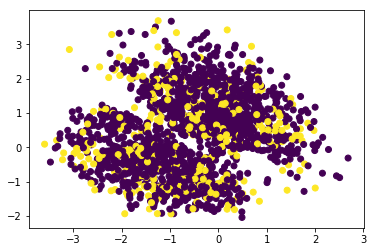

In [390]:
[z_mean_1, z_log_var_1, z_mean_2, z_log_var_2, z_1, z_2, predict_c, mu1, mu2] = encoder.predict([x_test,dummy_test,l_test],batch_size=batch_size)
color = np.ones(y_test.shape[0])
for i in range(0, y_test.shape[0]):
    if predict_c[i] < 0.5:
        color[i] = 0
        z_mean_1[i,:] = z_mean_2[i,:]
plt.scatter(z_mean_1[:, 0], z_mean_1[:, 1], c=color)

In [394]:
mu2

array([[-0.59865   ,  0.41332263],
       [-0.59865   ,  0.41332263],
       [-0.59865   ,  0.41332263],
       ...,
       [-0.59865   ,  0.41332263],
       [-0.59865   ,  0.41332263],
       [-0.59865   ,  0.41332263]], dtype=float32)

In [392]:
predict_c

array([[0.51489323],
       [0.5064235 ],
       [0.4986914 ],
       ...,
       [0.49029636],
       [0.4798968 ],
       [0.5020209 ]], dtype=float32)

In [315]:
l_test

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]])